In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LearningRateScheduler
from tensorboard.plugins.hparams import api as hp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import datetime

%load_ext tensorboard

In [32]:
# load dataset
#data = pd.read_json('/content/drive/MyDrive/Accountstory/data/TRAINING_dataset.json')
data = pd.read_json('/content/drive/MyDrive/Accountstory/data/TRAINING_dataset_20210930.json')
#data = pd.read_json('../../data/TRAINING_dataset.json')
data

,gender,stakeholder_category,us_name,uni_rank,degree_score,edu_industrial engineering,edu_organizational leadership,edu_management,edu_business administration,edu_business administration and management,edu_international business,edu_commerce,edu_economics,edu_software engineering,edu_mathematics,edu_design,edu_engineering,edu_product design,edu_business,edu_computer science,edu_electrical engineering,edu_photography,edu_art history,edu_italian culture,edu_communication,edu_biology,edu_neuroscience,edu_marketing,edu_film,edu_finance,edu_accounting,edu_computer engineering,edu_business finance,edu_political science and government,edu_political science,edu_government,edu_rhetoric,edu_medicine,edu_business marketing,edu_statistics,...,role_public_relations,role_sales,sub_role_accounting,sub_role_accounts,sub_role_brand_marketing,sub_role_business_development,sub_role_compensation,sub_role_content_marketing,sub_role_customer_success,sub_role_data,sub_role_devops,sub_role_editorial,sub_role_electrical,sub_role_employee_development,sub_role_events,sub_role_fitness,sub_role_graphic_design,sub_role_information_technology,sub_role_investment,sub_role_lawyer,sub_role_logistics,sub_role_network,sub_role_pipeline,sub_role_product,sub_role_product_design,sub_role_product_marketing,sub_role_professor,sub_role_project_management,sub_role_quality_assurance,sub_role_recruiting,sub_role_researcher,sub_role_security,sub_role_software,sub_role_support,sub_role_systems,sub_role_video,sub_role_web,sub_role_web_design,sub_role_wellness,sub_role_writing
0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1991,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1931,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,1,0,1,1982,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2755,-1,0,0,1701,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2756,-1,0,0,1766,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2757,1,0,0,1985,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [33]:
important_features = pd.read_csv('/content/drive/MyDrive/Accountstory/data/feat_importance.csv')
#important_features = pd.read_csv('../../data/feat_importance.csv')
important_features = list(important_features['gender'])

In [34]:
#X = data.drop('stakeholder_category', axis=1) # all Features
X = data[important_features]
y = data['stakeholder_category'] # Target variable

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X_test_scaled = scaler.transform(X_valid)
#X_test_scaled = scaler.transform(X_test)

In [36]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [16]:
#! rm -rf logs/
#%tensorboard --logdir logs/fit

In [ ]:
tf.random.set_seed(1234)

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))


METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [23]:
len([x for x in list((model.predict(X_test) > 0.5).astype("int32")[:,0]-np.array(y_test)) if x == 0])/len(y_test)

0.7777777777777778

Epoch 1/87
156/156 [==============================] - 2s 5ms/step - loss: 2.8822 - Accuracy: 0.5892 - val_loss: 2.7668 - val_Accuracy: 0.5761
Epoch 2/87
156/156 [==============================] - 1s 4ms/step - loss: 2.5667 - Accuracy: 0.6420 - val_loss: 2.5456 - val_Accuracy: 0.5942
Epoch 3/87
156/156 [==============================] - 1s 4ms/step - loss: 2.3700 - Accuracy: 0.6645 - val_loss: 2.3698 - val_Accuracy: 0.5942
Epoch 4/87
156/156 [==============================] - 1s 3ms/step - loss: 2.2002 - Accuracy: 0.6855 - val_loss: 2.2253 - val_Accuracy: 0.6087
Epoch 5/87
156/156 [==============================] - 1s 4ms/step - loss: 2.0747 - Accuracy: 0.6983 - val_loss: 2.1026 - val_Accuracy: 0.6051
Epoch 6/87
156/156 [==============================] - 1s 4ms/step - loss: 1.9539 - Accuracy: 0.7092 - val_loss: 1.9928 - val_Accuracy: 0.6123
Epoch 7/87
156/156 [==============================] - 1s 3ms/step - loss: 1.8425 - Accuracy: 0.7277 - val_loss: 1.8970 - val_Accuracy: 0.6377
Epoch 

(0.0, 1.0)

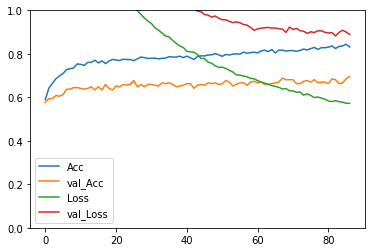

In [39]:
tf.random.set_seed(1234)

model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[X_train.shape[1]]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.LayerNormalization(axis=1),
                                 #keras.layers.Dense(3000, activation="relu"),
                                 keras.layers.Dense(100, activation="selu", kernel_regularizer='l2'), 
                                                    #kernel_constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=0)
                                                    #),
                                 #keras.layers.Dropout(.10),
                                 #keras.layers.BatchNormalization(),
                                 keras.layers.Dense(50, activation="selu", kernel_regularizer='l2'),
                                 #keras.layers.Dropout(.02),
                                 #keras.layers.Dense(10, activation="relu", kernel_regularizer='l1_l2'),
                                 #keras.layers.Dense(10, activation="relu"),
                                 #keras.layers.BatchNormalization(),

                                 keras.layers.Dense(1, activation="sigmoid")
                                 ])

model.compile(loss="binary_crossentropy",
              optimizer='adam',#f.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.1, nesterov=False, name='adam'),
              metrics=["Accuracy"],
              )

lr_sched = LearningRateScheduler(lambda epoch: 1e-4)

history = model.fit(X_train, y_train, 
                    epochs=87, 
                    batch_size = 16,
                    validation_data=(X_test, y_test),
                    callbacks=lr_sched,
                    )

# plot results
pd.DataFrame(np.array([history.history['Accuracy'],history.history['val_Accuracy'],history.history['loss'],history.history['val_loss']]).T).plot()
plt.legend(['Acc', 'val_Acc','Loss','val_Loss'])
plt.ylim(0, 1)

In [ ]:
tf.random.set_seed(1234)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[X_train.shape[1]]),
                                 keras.layers.BatchNormalization(),
                                 #keras.layers.LayerNormalization(axis=1),
                                 keras.layers.Dense(256, activation="relu"),
                                 #keras.layers.Dense(1000, activation="relu", 
                                                    #kernel_constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=0)
                                                    #),
                                 keras.layers.Dropout(.2),
                                 keras.layers.Dense(128, activation="relu", kernel_regularizer='l1_l2'),
                                 keras.layers.Dropout(.2),
                                 #keras.layers.Dense(10, activation="relu", kernel_regularizer='l1_l2'),
                                 #keras.layers.Dense(10, activation="relu"),
                                 keras.layers.Dense(1, activation="sigmoid")
                                 ])

model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=["Accuracy"],
              )

lr_sched = LearningRateScheduler(lambda epoch: 2e-4 * (0.9 ** np.floor(epoch/2)))

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size = 16,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard_callback,
                               lr_sched
                               ],
                    verbose=1)

# plot results
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)

# tune hyper params

In [ ]:
def run(batch, neurons_1, neurons_2, act, drop_1, drop_2, lr, epochs, verbose=0):
    tf.random.set_seed(1)
    model = keras.models.Sequential([
                                  keras.layers.Flatten(input_shape=[X_train.shape[1]]),
                                  keras.layers.BatchNormalization(),
                                  #keras.layers.LayerNormalization(axis=1),
                                  keras.layers.Dense(neurons_1, activation=act, kernel_regularizer='l1_l2'),
                                  #keras.layers.Dense(1000, activation="relu", 
                                                      #kernel_constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=0)
                                                      #),
                                  keras.layers.BatchNormalization(),
                                  keras.layers.Dropout(drop_1),
                                  keras.layers.Dense(neurons_2, activation=act, kernel_regularizer='l1_l2'),
                                  keras.layers.Dropout(drop_2),
                                  #keras.layers.Dense(10, activation="relu", kernel_regularizer='l1_l2'),
                                  #keras.layers.Dense(10, activation="relu"),
                                  keras.layers.Dense(1, activation="sigmoid")
                                  ])

    model.compile(loss="binary_crossentropy",
                    optimizer="adam",
                    metrics=["Accuracy"],
                )

    lr_sched = LearningRateScheduler(lambda epoch: lr)

    history = model.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size = batch,
                      validation_data=(X_test, y_test),
                      callbacks=[lr_sched],
                        verbose=verbose
                      )
  
    return max(history.history['val_Accuracy'])

In [ ]:
best = [0, 0, 0, 0, 0, 0, 0, 0]

batch = [16, 32]
neurons_1 = [16, 128, 512, 1024]
act = ['relu', 'selu']
drop_1 = [0, .1, .3, .5]
drop_2 = [0, .1, .3, .5]
lr = [1e-4, 3e-4]

for b in batch:
  for n1 in neurons_1:
    for n2 in [n1/4, n1/2]:
      for a in act:
        for d1 in drop_1:
          for d2 in drop_2:
            for l in lr:
              print('#' * 40)
              print('batch =', b)
              print('neurons_1 =', n1)
              print('neurons_2 =', n2)
              print('act =', a)
              print('dropout_1 =', d1)
              print('dropout_2 =', d2)
              print('lr =', l)
              print('#' * 40)
              
              acc = run(b, n1, n2, a, d1, d2, l, 50)
              if acc > best[0]:
                best = [acc, b, n1, n2, a, d1, d2, l]
              
              print('#' * 40)
              print('current:',round(acc,4))
              print('----')
              print('best:',round(best[0],4), best[1:])
              print('#' * 40)

In [ ]:
best

[0.7979797720909119, 16, 16, 8.0, 'selu', 0, 0, 0.0001]

Epoch 1/500
121/121 [==============================] - 1s 5ms/step - loss: 0.8031 - Accuracy: 0.5671 - val_loss: 0.7814 - val_Accuracy: 0.5773
Epoch 2/500
121/121 [==============================] - 0s 3ms/step - loss: 0.7022 - Accuracy: 0.6059 - val_loss: 0.7198 - val_Accuracy: 0.5990
Epoch 3/500
121/121 [==============================] - 0s 3ms/step - loss: 0.6579 - Accuracy: 0.6225 - val_loss: 0.6904 - val_Accuracy: 0.6051
Epoch 4/500
121/121 [==============================] - 0s 3ms/step - loss: 0.6329 - Accuracy: 0.6572 - val_loss: 0.6739 - val_Accuracy: 0.6111
Epoch 5/500
121/121 [==============================] - 0s 3ms/step - loss: 0.6105 - Accuracy: 0.6696 - val_loss: 0.6674 - val_Accuracy: 0.6135
Epoch 6/500
121/121 [==============================] - 0s 3ms/step - loss: 0.5968 - Accuracy: 0.6789 - val_loss: 0.6558 - val_Accuracy: 0.6256
Epoch 7/500
121/121 [==============================] - 0s 3ms/step - loss: 0.5838 - Accuracy: 0.6753 - val_loss: 0.6514 - val_Accuracy: 0.6220

(0.0, 1.0)

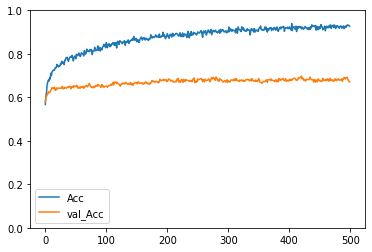

In [140]:
tf.random.set_seed(1234)
model = keras.models.Sequential([
                              keras.layers.Flatten(input_shape=[X_train.shape[1]]),
                              keras.layers.BatchNormalization(),
                              keras.layers.LayerNormalization(axis=1),
                              keras.layers.Dense(100, activation="selu"),
                              #keras.layers.Dense(1000, activation="relu", 
                                                  #kernel_constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=0)
                                                  #),
                              
                              #keras.layers.LayerNormalization(axis=1),
                              keras.layers.Dropout(.1),
                              #keras.layers.BatchNormalization(),
                              keras.layers.Dense(20, activation="selu"),
                              
                              keras.layers.Dropout(.1),
                              keras.layers.BatchNormalization(),
                              #keras.layers.Dense(8, activation="selu", kernel_regularizer='l1_l2'),
                              #keras.layers.Dense(10, activation="relu", kernel_regularizer='l1_l2'),
                              #keras.layers.Dense(10, activation="relu"),
                              keras.layers.Dense(1, activation="sigmoid")
                              ])

model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["Accuracy"],
            )

lr_sched = LearningRateScheduler(lambda epoch: 1e-4)

history = model.fit(X_train, y_train, 
                  epochs=500, 
                  batch_size = 16,
                  validation_data=(X_test, y_test),
                  callbacks=[lr_sched],
                  verbose=1
                  )

plt.plot(history.history['Accuracy'], label='Acc')
plt.plot(history.history['val_Accuracy'], label='val_Acc')
plt.legend()
plt.ylim(0,1)

In [30]:
y_pred = (model.predict(X_test) > 0.75).astype('int32')

In [25]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, y_pred, beta=1)

0.7608695652173914

Text(33.0, 0.5, 'Actual')

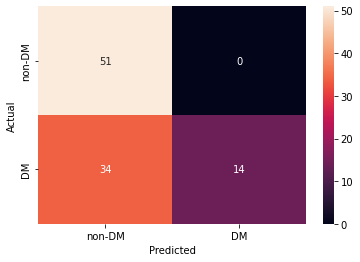

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = cm.ravel()

df_cm = pd.DataFrame(np.array([[tn, fp],[fn,tp]]), index = ['non-DM','DM'],
                  columns = ['non-DM','DM'])
plt.figure()


p=sn.heatmap(df_cm, annot=True)
p.set_xlabel('Predicted')
p.set_ylabel('Actual')

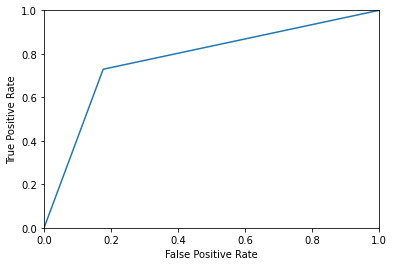

In [27]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()